# 🌳 A Deep Dive into Decision Tree Classifiers

**Objective:** This notebook provides a comprehensive, university-level exploration of the Decision Tree algorithm. We will cover the core mathematical principles, implement a tree from scratch in Python, and finally, leverage `scikit-learn` for a practical, real-world application, including visualization and hyperparameter tuning.

First, let's import all the necessary libraries we'll be using throughout this notebook.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## 🚀 Section 1: Introduction to Decision Trees

At its core, a Decision Tree is a supervised learning algorithm that functions like a flowchart. It sequentially asks questions about the features of your data to arrive at a decision, or in our case, a classification. Each internal node in the tree represents a "test" on a feature (e.g., "Is cholesterol > 200?"), each branch represents the outcome of the test, and each leaf node represents a class label (the final decision).

### Advantages:
- **High Interpretability:** The flowchart-like structure is easy to understand and explain to non-technical stakeholders. You can literally trace the path a decision takes.
- **Handles Non-linear Data:** Trees can capture complex, non-linear relationships between features and the target.
- **Minimal Data Prep:** They don't require feature scaling (like StandardScaler) and are robust to outliers to some extent.

### Disadvantages:
- **Prone to Overfitting:** A tree can grow very deep and complex, essentially memorizing the training data. This leads to poor performance on unseen data.
- **Instability:** Small variations in the data can result in a completely different tree being generated. This is often mitigated by using trees within an ensemble, like a Random Forest.

We will use the **UCI Heart Disease Dataset** for our analysis. Let's load it from its source URL and inspect its structure. The goal is to predict the presence of heart disease (`target`) based on a set of medical attributes.

In [3]:
# Load the dataset from the UCI repository
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
df = pd.read_csv(url, header=None, names=column_names, na_values='?')

# Data cleaning: drop rows with missing values and convert target to a binary classification (0 or 1)
df.dropna(inplace=True)
df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows of the dataset:")
df.head()

Dataset Shape: (297, 14)

First 5 rows of the dataset:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


Let's define our features (`X`) and the variable we want to predict (`y`).

In [4]:
X = df.drop('target', axis=1)
y = df['target']

print("Features (X) shape:", X.shape)
print("Target (y) shape:", y.shape)

Features (X) shape: (297, 13)
Target (y) shape: (297,)


## 🧠 Section 2: The Core Mathematics (A Deep Dive)

How does a decision tree decide *which* feature to split on and at *what* value? Imagine you're a cardiologist with a group of patients. Your goal is to ask a series of yes/no questions to separate the patients with heart disease from those without. A good question is one that results in two groups, where each group is more "pure" (i.e., more dominated by a single diagnosis) than the original, mixed group.

The algorithm quantifies this idea of "purity" using mathematical metrics. Let's explore the two most common ones: **Gini Impurity** and **Entropy**.

### Gini Impurity: The Probability of Misclassification

Think of Gini Impurity as answering this question: **If I randomly pick one patient from a group, and then randomly assign them a diagnosis based on the group's overall distribution, what's the probability I'm wrong?**

A Gini score of 0 means perfect purity (e.g., a group of patients who *all* have heart disease), making misclassification impossible. A score of 0.5 (for our binary case) means maximum impurity (a 50/50 split), where you have a 50% chance of guessing wrong.

#### Deconstructing the Gini Formula

The formula looks intimidating, but it's built from simple probabilities. Let's use the more intuitive version:

$$G = 1 - \sum_{i=1}^{C} p(i)^2$$

Let's break it down piece-by-piece for our heart disease case (where $C=2$ classes: `0: No Disease`, `1: Disease`):

1.  **$p(i)$**: This is simply the probability of a patient belonging to class $i$. If a group has 10 patients and 7 have no disease, then $p(0) = 7/10 = 0.7$.
2.  **$p(i)^2$**: This is the probability of randomly picking two patients (with replacement) *from the same class $i$*. If $p(0) = 0.7$, then $p(0)^2 = 0.49$. This means there's a 49% chance of picking two "No Disease" patients in a row.
3.  **$\sum p(i)^2$**: This is the *total probability of agreement*. It's the probability that if we pick two random patients, they will have the *same* diagnosis. It's calculated as: `(Prob. of picking two 'No Disease') + (Prob. of picking two 'Disease')`. This sum is a measure of **purity**. A high value means the group is homogeneous.
4.  **$1 - \sum p(i)^2$**: This is the complement. If $\sum p(i)^2$ is the probability of agreement, then $1 - \sum p(i)^2$ is the probability of *disagreement*. This is our Gini Impurity score—the probability that two randomly chosen patients will have *different* diagnoses.

#### Numerical Example: A Split on Chest Pain Type (`cp`)

Let's say our **Parent Node** (before any split) has **100 patients**:
* **60** have 'No Disease' (Class 0)
* **40** have 'Disease' (Class 1)

**Gini of the Parent Node:**
* $p(0) = 60/100 = 0.6$
* $p(1) = 40/100 = 0.4$
* Purity ($\sum p(i)^2$) = $(0.6)^2 + (0.4)^2 = 0.36 + 0.16 = 0.52$
* **Gini Impurity = $1 - 0.52 = 0.48$**

Now, the tree considers a split. Let's test the feature `cp` (chest pain type). Suppose a split on `cp <= 2` gives us two child nodes:

* **Child 1 (`cp <= 2`)**: **70 patients**
    * **55** 'No Disease' (Class 0)
    * **15** 'Disease' (Class 1)
* **Child 2 (`cp > 2`)**: **30 patients**
    * **5** 'No Disease' (Class 0)
    * **25** 'Disease' (Class 1)

**Calculate Gini for each Child:**
* **Gini (Child 1)**: $1 - \left( \left(\frac{55}{70}\right)^2 + \left(\frac{15}{70}\right)^2 \right) \approx 1 - (0.786^2 + 0.214^2) \approx 1 - 0.664 = \mathbf{0.336}$
* **Gini (Child 2)**: $1 - \left( \left(\frac{5}{30}\right)^2 + \left(\frac{25}{30}\right)^2 \right) \approx 1 - (0.167^2 + 0.833^2) \approx 1 - 0.722 = \mathbf{0.278}$

Notice both child nodes are purer (have lower Gini scores) than the parent node (0.48)!

**Calculate the final score for the split (Gini Gain):**
To see how good the split was overall, we take the weighted average of the children's Gini scores.
* Weighted Gini = $(\frac{70}{100} \times 0.336) + (\frac{30}{100} \times 0.278) = (0.7 \times 0.336) + (0.3 \times 0.278) = 0.2352 + 0.0834 = \mathbf{0.3186}$

The **Gini Gain** (or impurity reduction) is:
* Gini Gain = Gini(parent) - Weighted Gini(children) = $0.48 - 0.3186 = \mathbf{0.1614}$

The algorithm calculates this gain for every possible split on every feature and chooses the one with the **highest Gini Gain**.

---

### Entropy and Information Gain: The Measure of Uncertainty

Entropy comes from information theory and answers the question: **How much uncertainty or surprise is there in this group of patients?**

* **Zero Entropy**: A "pure" node (e.g., all patients have 'No Disease'). There's no uncertainty. The surprise is zero.
* **Maximum Entropy (1.0 for binary case)**: An "impure" node (e.g., 50/50 split). The uncertainty is maximized. You are most surprised by the outcome because it's completely unpredictable.

**Information Gain** is then the reduction in that uncertainty. It answers: **How much did my uncertainty decrease after I asked a question (made a split)?**

#### Deconstructing the Entropy and IG Formulas

**Entropy Formula:**
$$H(S) = - \sum_{i=1}^{C} p_i \log_2(p_i)$$
* **$p_i$**: Same as before, the proportion of samples in class $i$.
* **$\log_2(p_i)$**: This term is the core of "surprise". For a rare event ($p_i$ is small), its logarithm is a large negative number. For a common event ($p_i$ is large), its logarithm is a small negative number.
* **$- p_i \log_2(p_i)$**: The negative sign makes the result positive. This term can be thought of as the "contribution to total uncertainty" from class $i$.

**Information Gain (IG) Formula:**
$$IG(S, A) = H(S) - \sum_{v \in Values(A)} \frac{|S_v|}{|S|} H(S_v)$$
This is simply: **Information Gain = (Uncertainty Before Split) - (Weighted Uncertainty After Split)**.

#### Numerical Example: The Same Split on Chest Pain

Let's use the same parent node and split as before.

**Parent Node** (60 'No Disease', 40 'Disease'):
* **Entropy(Parent)**: $-\left( \frac{60}{100}\log_2(\frac{60}{100}) + \frac{40}{100}\log_2(\frac{40}{100}) \right) = -(0.6 \times -0.737 + 0.4 \times -1.322) \approx \mathbf{0.971}$

**Child Nodes** from the `cp <= 2` split:
* **Child 1**: 55 'No Disease', 15 'Disease'
    * **Entropy(Child 1)**: $-\left( \frac{55}{70}\log_2(\frac{55}{70}) + \frac{15}{70}\log_2(\frac{15}{70}) \right) \approx \mathbf{0.753}$
* **Child 2**: 5 'No Disease', 25 'Disease'
    * **Entropy(Child 2)**: $-\left( \frac{5}{30}\log_2(\frac{5}{30}) + \frac{25}{30}\log_2(\frac{25}{30}) \right) \approx \mathbf{0.650}$

**Calculate Information Gain:**
First, get the weighted average entropy of the children:
* Weighted Entropy = $(\frac{70}{100} \times 0.753) + (\frac{30}{100} \times 0.650) = 0.5271 + 0.195 = \mathbf{0.7221}$

Now, find the reduction in uncertainty:
* **Information Gain** = Entropy(Parent) - Weighted Entropy(Children) = $0.971 - 0.7221 = \mathbf{0.2489}$

The algorithm would calculate this gain and pick the split with the **highest Information Gain**.

---
### Gini vs. Entropy

While the numbers are different, the outcome is the same: a split on `cp <= 2` is better than no split at all. In practice, both metrics almost always choose the same splits. **Gini Impurity is the default in scikit-learn because it's faster to compute**—it avoids the logarithm calculation, which is more computationally expensive than squaring.

## ⚙️ Section 3: Algorithm in Action (How the Tree is Actually Built)

The math tells us how to *score* a potential split, but how does the algorithm use this score to build the tree from scratch? The process is a **greedy, recursive search**. "Greedy" means it makes the best possible decision at each step, without looking ahead to see if a different choice now might lead to a better overall tree later. "Recursive" means it repeats the same process on smaller and smaller subsets of the data.

Here is the step-by-step logic, which directly answers the question: "How did it decide *those* were the features to consider?"

--- 

### Step 1: Start with Everyone in One Room (The Root Node)

The algorithm begins with the entire training dataset. In our example, all 237 training patients are in a single group, which will become the **root node** of the tree. The algorithm first calculates the starting impurity (e.g., Gini score) of this complete group. This is the baseline impurity it will try to reduce.

--- 

### Step 2: Find the Single Best Question to Ask (The Best Split)

This is the core of the algorithm. To find the best split, it performs an exhaustive search:

1.  **Loop Through Every Feature:** The algorithm iterates through every feature available: `age`, `sex`, `cp`, `trestbps`, `thalach`, etc.
2.  **Loop Through Every Possible Split for That Feature:**
    * For a **continuous feature** like `thalach` (max heart rate), it will identify every unique value (e.g., 96, 97, 98...) and test a split at each one (e.g., `thalach <= 96`, `thalach <= 97`, etc.).
    * For a **categorical feature** like `sex` (0 or 1), it will test the split `sex <= 0`.

3.  **Score Each Potential Split:** For every single one of these potential splits, the algorithm performs a hypothetical division of the data and calculates the resulting **Information Gain** (or Gini Gain). For example, it will calculate:
    * Gain if we split on `age <= 58`
    * Gain if we split on `thalach <= 150`
    * Gain if we split on `cp <= 2`
    * ...and so on for hundreds of possible splits.

4.  **Identify the Winner:** After checking them all, the algorithm identifies the **one feature and one threshold** that produced the absolute highest gain. 

--- 

### Step 3: Make the Split and Divide the Patients

The winning split from Step 2 is now made permanent. For instance, in our pruned tree visualization, the best first split for the entire dataset was `ca <= 0.5`. This means that out of all features and all thresholds, this specific question did the best job of separating patients with and without heart disease, maximizing the reduction in impurity.

The root node is now connected to two new child nodes: one containing all patients with `ca <= 0.5` and another with all patients where `ca > 0.5`.

--- 

### Step 4: Repeat the Process (Recursion)

Now, the algorithm treats each child node as a new, smaller, independent problem and **repeats the entire process from Step 2**.

* **For the `ca <= 0.5` node:** It looks only at the patients in *that group* and asks: "For this specific group, what is the best feature and threshold to split on *next*?" It again iterates through all features, finds the best split (which turned out to be `thal <= 2.5`), and splits this node further.
* **For the `ca > 0.5` node:** It does the same thing independently for the other group of patients.

This process continues, building the tree level by level.

--- 

### Step 5: Know When to Stop

This recursion doesn't go on forever. A branch stops growing and becomes a **leaf node** if any of the stopping criteria (hyperparameters) are met:

* **`max_depth` is reached:** Our pruned tree stopped at a depth of 4 because we explicitly set `max_depth=4`.
* **Node is Pure:** If a node contains patients with only one diagnosis (Gini = 0), there's no reason to split it further.
* **`min_samples_split` or `min_samples_leaf` is violated:** If a node has too few patients to split, or if a split would result in a leaf with too few patients, the algorithm will halt for that branch.

Once a node becomes a leaf, the prediction for that leaf is simply the majority class of the patients it contains. That's how the tree makes a final decision.

## 🛠️ Section 4: Building a Decision Tree from Scratch (Pure Python)

To truly understand the algorithm, let's implement it from the ground up. We will use Information Gain as our splitting criterion. This implementation will be a simplified version but will capture the core recursive logic.

First, we define a `Node` class. This class will store information about the split (feature, threshold) or the final class prediction if it's a leaf node.

In [6]:
class Node:
    """
    A node in the decision tree.
    
    Attributes:
        feature (int): Index of the feature to split on.
        threshold (float): Threshold value for the feature split.
        left (Node): Left child node.
        right (Node): Right child node.
        value (int): The predicted class label if the node is a leaf.
    """
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

Now, we define the main `DecisionTree` class. It will contain the `fit` method to build the tree and the `predict` method to make classifications.

In [16]:
class CustomDecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None
    
    def fit(self, X, y):
        # The `fit` method kicks off the recursive tree-growing process
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # Stopping criteria for recursion
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        # Find the best feature and threshold to split on
        best_feature, best_thresh = self._best_split(X, y, n_features)

        # If a split is found, create child nodes recursively
        if best_feature is not None:
            left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
            left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
            right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
            return Node(best_feature, best_thresh, left, right)
        
        # If no useful split is found, create a leaf node
        leaf_value = self._most_common_label(y)
        return Node(value=leaf_value)

    def _best_split(self, X, y, n_features):
        best_gain = -1
        split_idx, split_thresh = None, None

        for feat_idx in range(n_features):
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for thr in thresholds:
                gain = self._information_gain(y, X_column, thr)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = thr

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, threshold):
        # Parent entropy
        parent_entropy = self._entropy(y)

        # Create children
        left_idxs, right_idxs = self._split(X_column, threshold)
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # Weighted average of children's entropy
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # Information gain is the difference
        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])

    def _most_common_label(self, y):
        counter = Counter(y)
        if not counter:
            return 0 # Default value
        most_common = counter.most_common(1)[0][0]
        return most_common

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

Now let's train our custom tree and evaluate its performance. We first need to split our data into training and testing sets.

In [8]:
# Prepare data for training
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, test_size=0.2, random_state=42
)

# Instantiate and train the custom tree
custom_tree = CustomDecisionTree(max_depth=5)
custom_tree.fit(X_train, y_train)

# Make predictions
y_pred_custom = custom_tree.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_custom)
print(f"Accuracy of the custom-built Decision Tree: {accuracy:.4f}")

Accuracy of the custom-built Decision Tree: 0.8167


## ⚙️ Section 5: Implementation with Scikit-Learn

While building a tree from scratch is an excellent learning exercise, in any practical setting, you'll use a highly optimized library like `scikit-learn`. The process is much more straightforward.

First, we'll create new training and testing sets from the pandas DataFrame, as `scikit-learn` works well with them directly.

In [17]:
X_train_sk, X_test_sk, y_train_sk, y_test_sk = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Now, we instantiate `DecisionTreeClassifier`, fit it to the training data, and make predictions. Note that `scikit-learn` uses an optimized version of the CART algorithm and defaults to Gini impurity.

In [18]:
# Instantiate the classifier
clf = DecisionTreeClassifier(random_state=42)

# Fit the model to the training data
clf.fit(X_train_sk, y_train_sk)

# Make predictions on the test data
y_pred_sk = clf.predict(X_test_sk)

Let's evaluate the `scikit-learn` model's performance using standard metrics.

Accuracy of scikit-learn Decision Tree: 0.7833

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.87      0.75      0.81        36
     Disease       0.69      0.83      0.75        24

    accuracy                           0.78        60
   macro avg       0.78      0.79      0.78        60
weighted avg       0.80      0.78      0.79        60


Confusion Matrix:


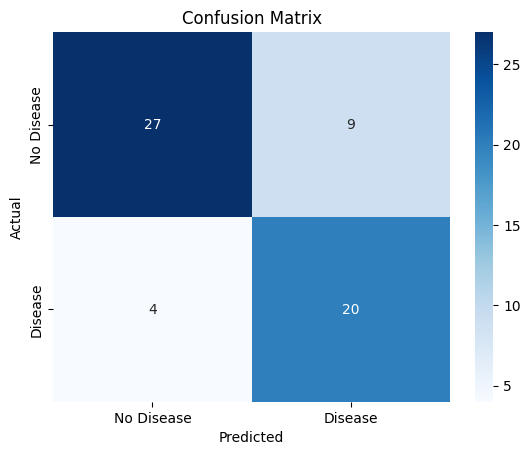

In [19]:
accuracy_sk = accuracy_score(y_test_sk, y_pred_sk)
print(f"Accuracy of scikit-learn Decision Tree: {accuracy_sk:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_sk, y_pred_sk, target_names=['No Disease', 'Disease']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test_sk, y_pred_sk)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### 📊 Visualizing the Tree

One of the greatest strengths of a decision tree is its interpretability. We can directly visualize the entire logic of the trained model. Each node shows the splitting criteria, the Gini impurity score, the number of samples at that node, and the class distribution (`value`).

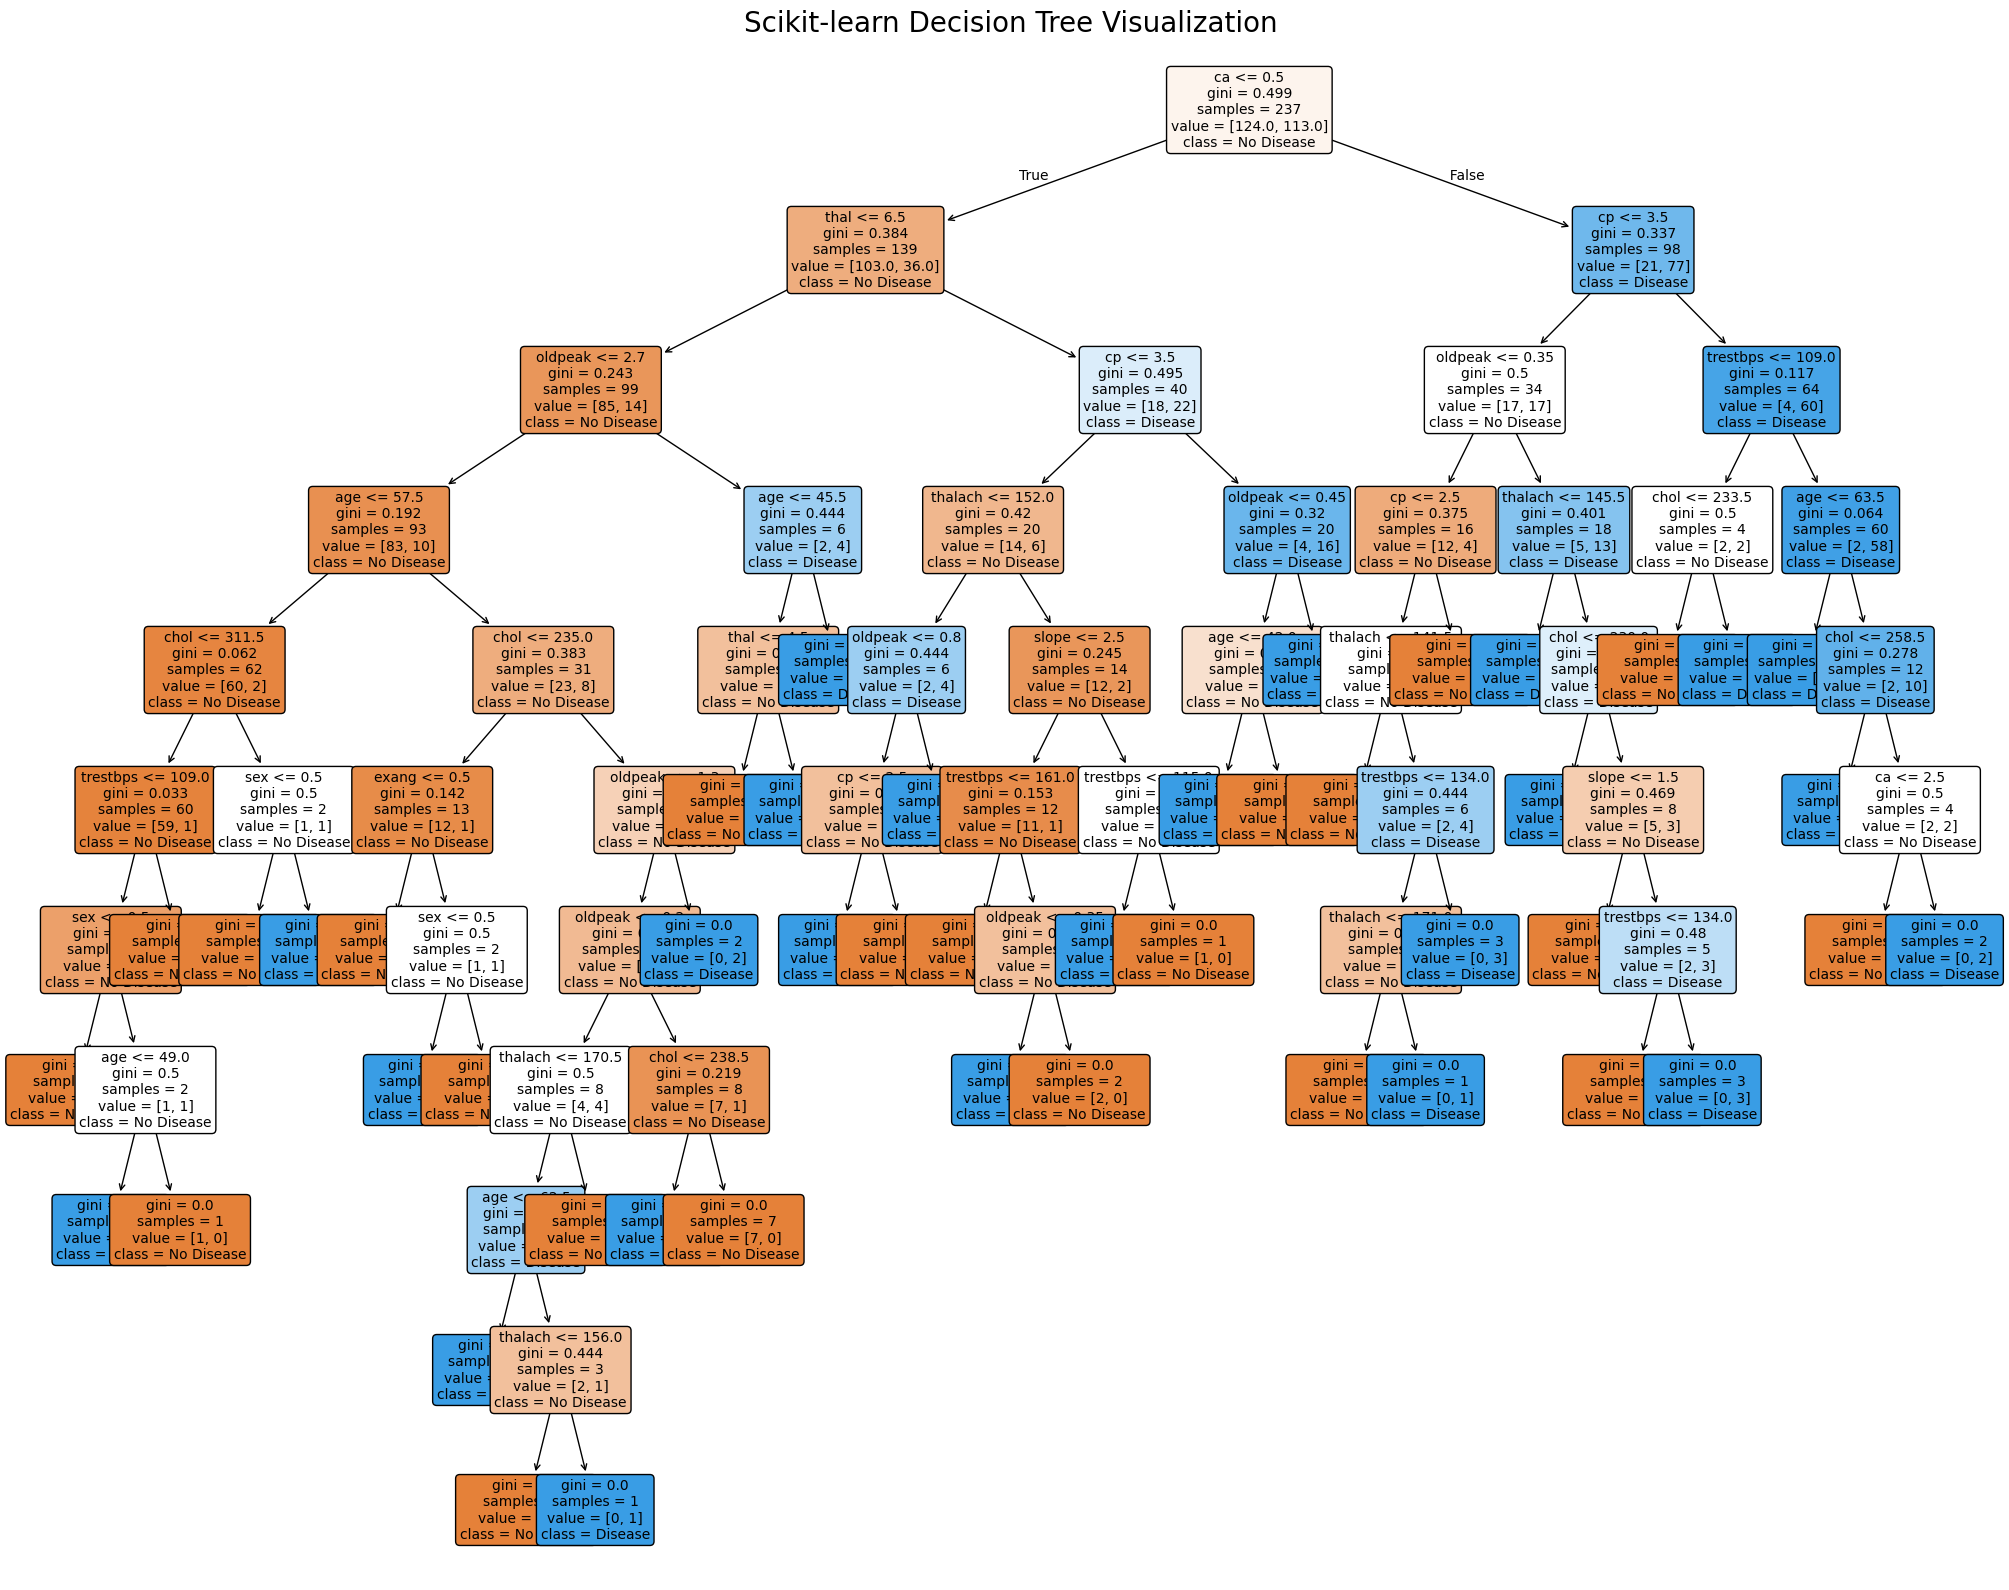

In [12]:
plt.figure(figsize=(25, 20))
plot_tree(
    clf, 
    filled=True, 
    rounded=True, 
    class_names=['No Disease', 'Disease'], 
    feature_names=X.columns,
    fontsize=10
)
plt.title("Scikit-learn Decision Tree Visualization", fontsize=20)
plt.show()

## ⚠️ Section 6: Overfitting and Hyperparameter Tuning

Look at the tree above. It's incredibly deep and complex. Some leaf nodes have very few samples. This is a classic sign of **overfitting**. The tree has learned the noise and specific quirks of the training data so well that it is unlikely to generalize to new, unseen data.

To combat this, we perform **pruning**, which is a technique to reduce the size and complexity of the tree. We don't do this manually; instead, we control the tree's growth by tuning its hyperparameters *before* training.

Key hyperparameters include:
- `max_depth`: The maximum depth the tree is allowed to grow. A smaller number constrains the model and reduces overfitting.
- `min_samples_split`: The minimum number of samples a node must have before it can be split. Prevents splitting on nodes with only a handful of samples.
- `min_samples_leaf`: The minimum number of samples that must exist in a leaf node after a split. This ensures that our final decision nodes are based on a reasonably sized population.

Let's train a new, constrained tree by setting `max_depth` and `min_samples_leaf` to see how it affects the result.

In [13]:
# Instantiate a 'pruned' or constrained classifier
clf_pruned = DecisionTreeClassifier(
    max_depth=4,
    min_samples_leaf=5,
    random_state=42
)

# Fit and predict
clf_pruned.fit(X_train_sk, y_train_sk)
y_pred_pruned = clf_pruned.predict(X_test_sk)

accuracy_pruned = accuracy_score(y_test_sk, y_pred_pruned)
print(f"Accuracy of Pruned Decision Tree: {accuracy_pruned:.4f}")

Accuracy of Pruned Decision Tree: 0.7667


Notice that the accuracy might be slightly lower than the fully grown tree on this specific test set, but this simpler model is far more likely to be robust and perform consistently on new data. Let's visualize this pruned tree to see the difference in complexity.

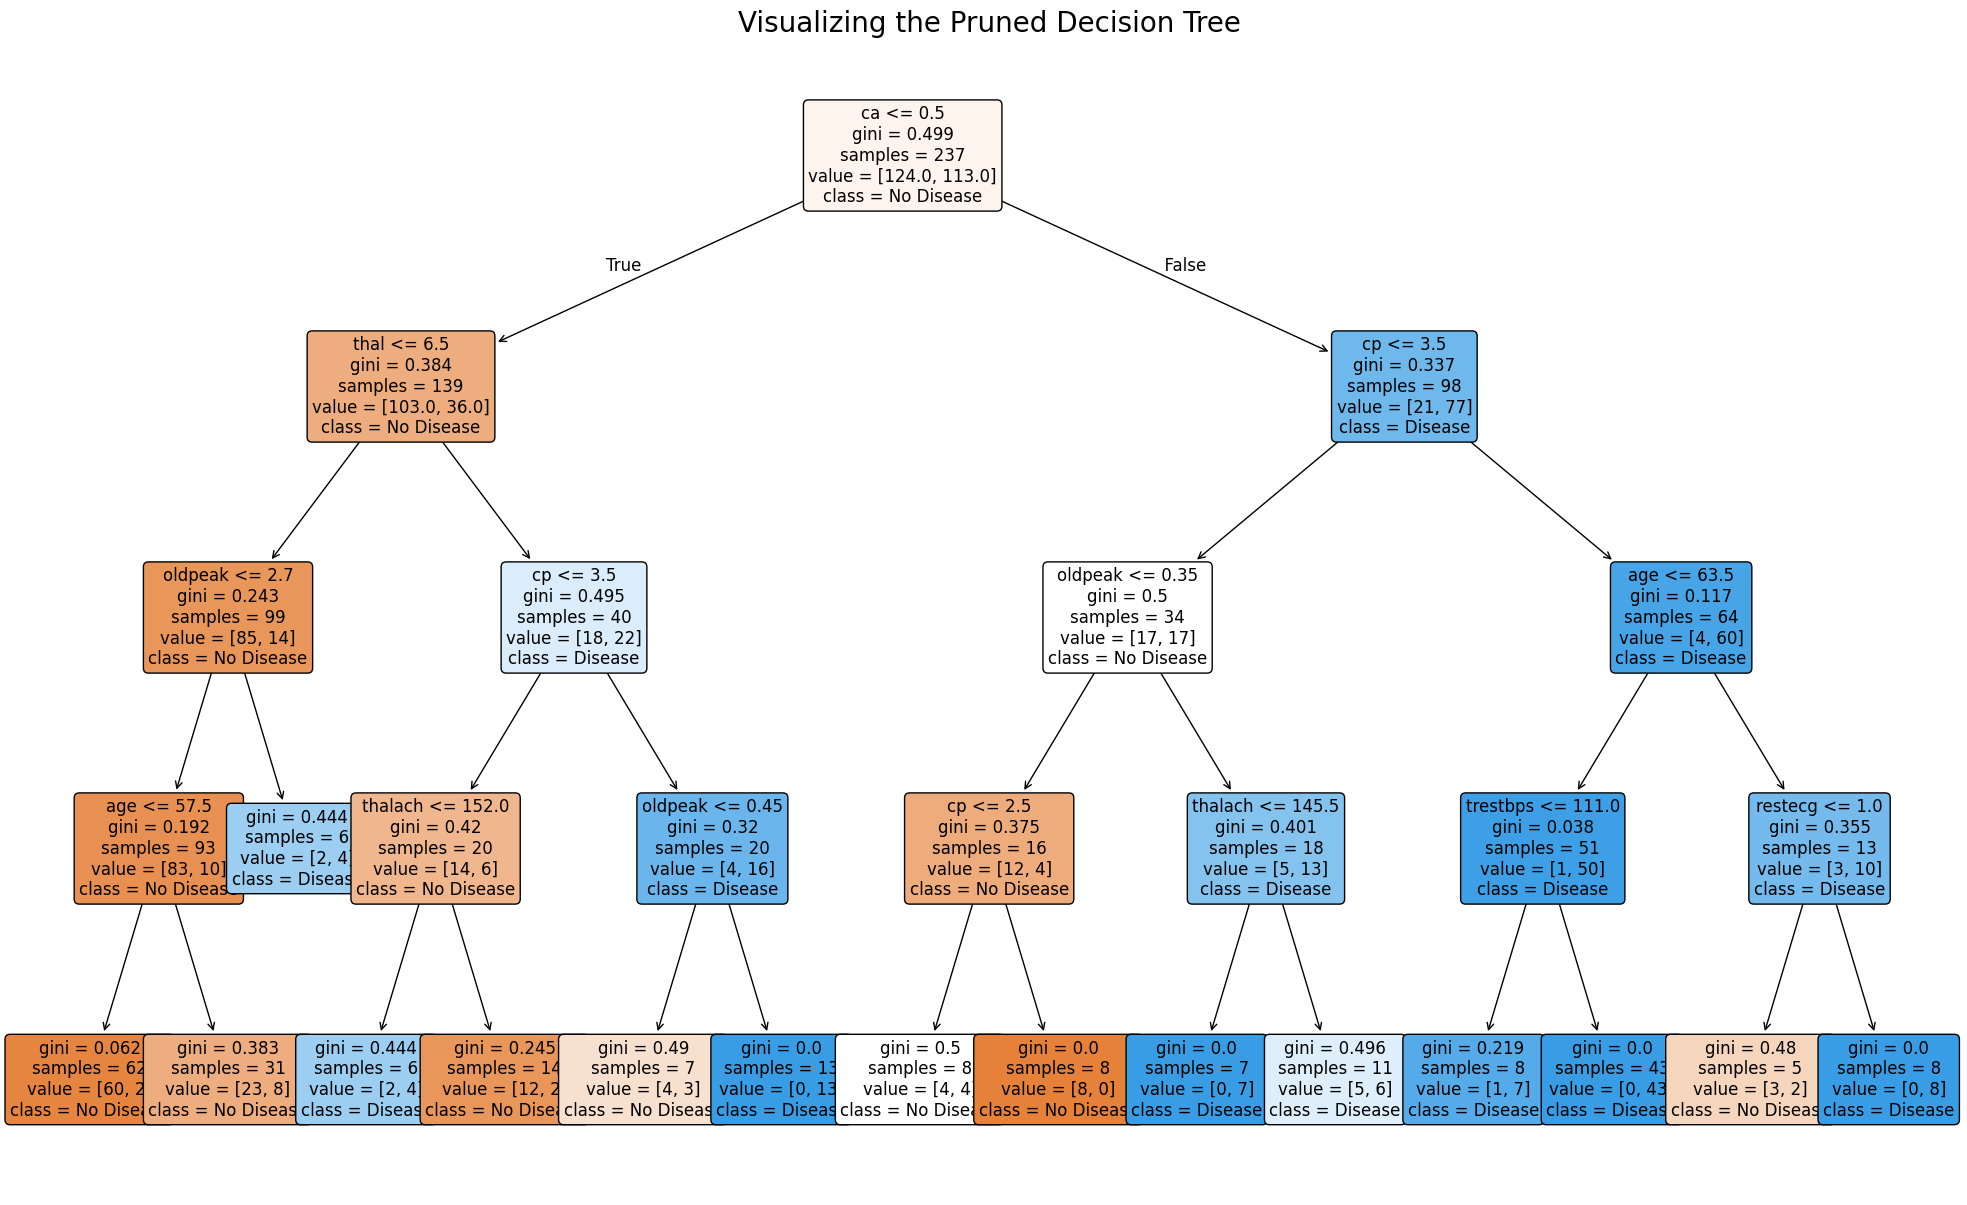

In [15]:
plt.figure(figsize=(25, 15))
plot_tree(
    clf_pruned, 
    filled=True, 
    rounded=True, 
    class_names=['No Disease', 'Disease'], 
    feature_names=X.columns,
    fontsize=12
)
plt.title("Visualizing the Pruned Decision Tree", fontsize=20)
plt.show()

## ✅ Section 7: Conclusion

In this notebook, we explored the Decision Tree classifier from multiple angles:

1.  **Theory:** We understood that trees make splits by maximizing **purity**, using metrics like **Gini Impurity** and **Information Gain** to guide the process.
2.  **From Scratch:** We implemented the core recursive logic ourselves to gain a fundamental understanding of how features and thresholds are chosen to build the tree.
3.  **Practical Application:** We used `scikit-learn` to efficiently build, evaluate, and visualize a tree, demonstrating the standard workflow in a real project.
4.  **Robustness:** We learned that decision trees are highly prone to **overfitting** and saw how tuning hyperparameters like `max_depth` is a critical step in creating a more generalizable and robust model.

Decision Trees are not only powerful standalone classifiers but also form the fundamental building block for more advanced ensemble methods like Random Forests and Gradient Boosted Trees. Their primary advantage remains their unparalleled **interpretability**, making them an invaluable tool in domains like medicine, finance, and any field where understanding the 'why' behind a prediction is just as important as the prediction itself.